# SNIa Selection Function Fitting for BAHAMAS
Using Logistic Regression in scikit-learn to predict whether or not a supernova will be selected for follow-up in an astronomical survey. This is a two-class classification problem; we want to know what attributes of a supernova (SN) will make it more likely to be classified as "selected" or "missed".

This notebook is for visualizing a small piece of our statistical pipeline. This routine will be incorporated in the consise "logreg.py" module in the BAHAMAS repository.


Notebook flow inspired by http://nbviewer.jupyter.org/gist/justmarkham/6d5c061ca5aee67c4316471f8c2ae976

## Logistic Regression Background

We'll assign a latent variable $Z_i$ = {1 for "selected", 0 for "missed"} to represent each SN$_i$'s classification. We want to know the probability of selecting each SN$_i$ (between 0 and 1) so we'll fit a "selection function" to smoothly connect $Z_i$ = 1 to $Z_i$ = 0. This function is called the **sigmoid function** and maps a continuous $x$ space as a probability $p$ between 0 and 1 (in this case, our two classes):


 $$p = \frac{1}{(1 + e^{-\beta x})}$$ 

By fitting this sigmoid model to a set of supernovae **whose $Z_i$ selection value is known** for the coefficient $\beta$ for a given parameter $x$, we can then use the fitted model to **guess the probability of selection on a new set of SNe whose selection is unknown**.


## Our Supernova Dataset

All data come from simulations, which will be used to test a Bayesian hierarchical inference routine. 
When we run SNANA simulations to generate our supernovae (SNe), all generated SNe are dumped in a bulk file with "truth" values for the latent inputs:


- $mB$ : apparent B-band magnitude
- $c$  : color (distribution centered on 0)
- $x1$ : "stretch" or duration of SN event


Once we've created a bulk data file, we pretend to "observe" a subset of our generated SNe. Processing cuts designed for real observations are applied. The remaining SNe are now dubbed "selected" since they passed hidden thresholds in the above latent inputs. These thresholds, that separate **bulk SNe** from **selected SNe**, are what we're trying to define.

In [1]:
# modules we need for the analysis
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
# turn off annoying write warnings in pandas
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt

In [2]:
import pylab as pl
import scipy

In [3]:
# Workaround for "chisqprob" missing module in scipy
from scipy import stats
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

## Data Cleaning

In [4]:
# first we're going to make the text file readable by pandas using a helper function I wrote
import cleanup

fname = '/mnt/c/Users/lucas/Datasets/bahamas/selection_fitting/Lucas_TEST_smearC11/FITOPT001.FITRES'
cleanup.fitresCleanup(fname)
fname = '/mnt/c/Users/lucas/Datasets/bahamas/selection_fitting/Lucas_TEST_smearC11/SIMGEN.DAT'
cleanup.simgenFileCleanup(fname)

In [5]:
# load data from smearC11 (glare type) FITRES files
data_sel = pd.read_csv('/mnt/c/Users/lucas/Datasets/bahamas/selection_fitting/Lucas_TEST_smearG10/FITOPT001_selected.FITRES', sep='\s+')  # selected SNe
data_all = pd.read_csv('/mnt/c/Users/lucas/Datasets/bahamas/selection_fitting/Lucas_TEST_smearG10/SIMGEN_bulk.DAT', usecols=['CID', "S2x0", 'S2x1', 'S2c', 'GENZ', 'NON1A_INDEX'], sep='\s+') # bulk simulated SNe

In [6]:
for name in ['S2x0', 'S2x1', 'S2c', "GENZ"]:
    data_all.loc[:, name] = data_all.loc[:,name].astype(float)
    
for name in ['zHEL', 'SIM_c', 'SIM_mB', 'SIM_x1']:
    data_sel.loc[:, name] = data_sel.loc[:,name].astype(float)

In [7]:
# convert simulated x0 to mB
S2mB = [(-2.5 * np.log10(x0) + 10.6) for x0 in data_all['S2x0']]
data_all.loc[:,'S2mB'] = pd.Series(data=S2mB, index=data_all.index)
data_all;

/home/lucas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


In [8]:
# remove nan values to be able to work with the data

data_all.replace([np.inf, -np.inf], np.nan)
data_all = data_all.dropna(axis=0,how='any')

In [9]:
len(data_all)

33596

We want to know which of the bulk SNe ended up being selected. We're going to use the numpy intersect method to compare the selected SNe ID tags with the bulk SNe ID tags. We'll end up with an array of ID tags that we can then use to create a selection flag. **If a selected SNe is found in the bulk dataframe, we'll add a a Boolean tag (1=selected, 0=missed) to a column called "selection_tag".**

In [10]:
intersect = np.intersect1d((data_all['CID']).astype(int), (data_sel['CID']))
print(intersect.size, "SNe in selected file AND bulk file")

8639 SNe in selected file AND bulk file


In [11]:
# using inbuilt Python object "in" structure setup, we can quickly compare our ID tags from data_sel and data_all:
selectIDs = []
for name in data_all['CID'].astype(int):
    if name in intersect:
        selectIDs.append(1) 
    else:
        selectIDs.append(0)
len(selectIDs)

33596

In [12]:
# add to Pandas table data_all:
data_all.loc[:,'selection_tag'] = pd.Series(data=selectIDs, index=data_all.index)
# convert redshift values from string to floats in data_all
data_all.loc[:,'GENZ'] = data_all['GENZ'].astype(float)

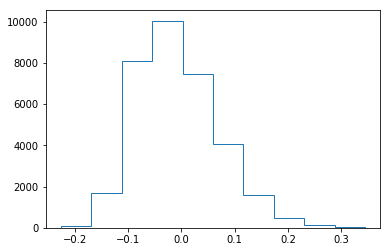

In [13]:
plt.hist(data_all['S2c'], histtype='step')
plt.show()

## Cutting out Junk SNe
Some of the supernovae generated by SNANA simulations aren't actually viable Type Ia -- many are what we call "core collapse" SNe, so many of the latent variables are "undetectable" in our simulation. Let's take them out!

In [14]:
# all non-Ia SNe are labeled with a string ID > 0. Let's create a boolean mask to remove them
snia_mask = np.invert((data_all['NON1A_INDEX'].values.astype(int) > 0).astype(bool))
# rewrite bulk dataset for just snia
data_all = data_all.iloc[snia_mask]
print(str(sum(snia_mask.astype(int))) + " Type Ia supernovae in bulk dataset")

33596 Type Ia supernovae in bulk dataset


In [15]:
# remove -9 placeholder valued SNe in selection file
snia_sel = data_sel['SIM_c'].values.astype(int) > -9
snia_sel &= data_sel['SIM_mB'].values.astype(int) > 0
snia_sel &= data_sel['SIM_x1'].values.astype(int) > -9

In [16]:
# re-write the selected dataframe for viable SNIa:
data_sel = data_sel.iloc[snia_sel]
print(str(len(data_sel)), " non-core collapse Type Ia SNe in selected dataset")

8639  non-core collapse Type Ia SNe in selected dataset


## SNIa Latent Plots

It's useful to also look at the distributions of SNIa latent variables in the bulk data. We're going to compare the "Total", "Missed", and "Selected" populations of the bulk dataset.

In [17]:
selected_mask = data_all['selection_tag'].values.astype(bool)
missed_mask = np.invert(selected_mask)
print(str(sum(missed_mask)) + " missed SNe in bulk data")

24957 missed SNe in bulk data


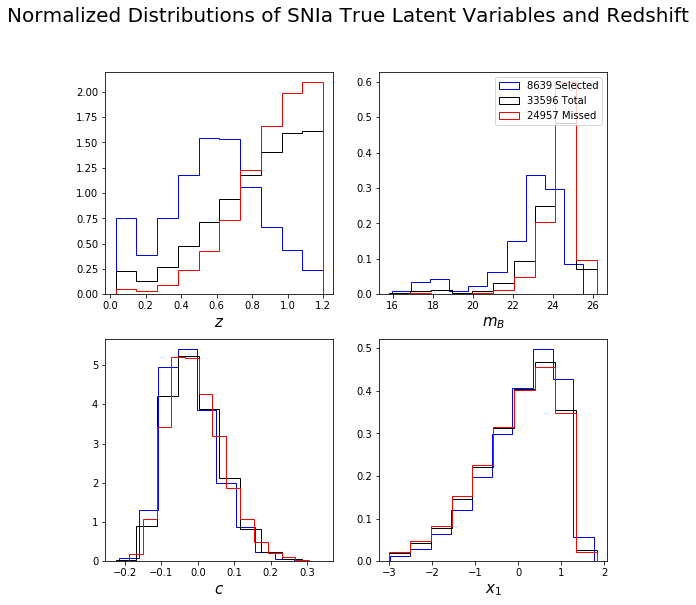

In [18]:
# Let's take a look at the OBSERVED SNe... We're going to "zoom in" on the normally-distributed populations from the plots above

# define lists of plotting features for latent mB, c, & x1
sel_names = ["zHEL", "SIM_mB", 'SIM_c', 'SIM_x1']
obs_names = ["GENZ", 'S2mB', 'S2c', 'S2x1']
labels = ['$z$', '$m_B$', '$c$', '$x_1$']
allbinz = [10, 10, 10, 10]
selbinz = [10, 10, 10, 10]
missedbinz = [10, 10, 15, 10]
xlims = [(0, 1.3),(14, 30), (-0.5, 0.5), (-4, 2)]

# make the plot
fig,axs = plt.subplots(2, 2, figsize = (9,9))

# sum number of objects in each category
selsum = str(len(data_sel))
observedsum = str(len(data_all))
missedsum = str(sum(missed_mask))

# flatten axes list to iterate over them
axs = np.ravel(axs)

for i in range(len(axs)):
    # selected Ia SNe
    axs[i].hist(data_sel[sel_names[i]], histtype='step', bins=selbinz[i], color='b', label=selsum +' Selected', stacked=False, density=True)
    # bulk Ia SNe
    axs[i].hist(data_all[obs_names[i]], histtype='step', bins=allbinz[i], color='k', label= observedsum + ' Total', stacked=False, density=True)
    # add missed Ia SNe
    axs[i].hist(data_all[obs_names[i]].iloc[missed_mask], histtype='step', bins=missedbinz[i], color='r', label= missedsum + ' Missed', stacked=False, density=True)
    # plot labels
    axs[i].set_xlabel(labels[i], fontsize=15)
    axs[i].set_xlabel(labels[i], fontsize=15)
    
    #axs[i].set_xlim(xlims[i]|)

fig.suptitle("Normalized Distributions of SNIa True Latent Variables and Redshift", fontsize=20)
axs[1].legend(loc='best')
plt.show()

Plots normalized to peak value in each category: "selected", "missed" and "bulk & observed".

Note that of the variables, redshift and B-band magnitude mB have the **greatest effect on shaping the "selected" peak of SNIa.** We can't fit our logistic regression function to redshift, since the bigger hierarchical model won't take it into effect. But we can look at the other three latent variables.

## Probit Regression using Scikit-Learn
Using the scikit-learn module, we're going to fit for our logistic regression coefficients. We're going to make use of the patsy dmatrices module to make our intercept column to fit to. 

$\phi$ is our vector of latent variables: $\phi = [m_B, c, x_1]$. $Z$ is the vector what we're fitting to: for each $SN_i$, $Z_i = \{0$ ~ "missed" OR $1$ ~ "selected"\}. 

Let's define our selection function. The probability that a SN is classified as "selected" is:
 $$p_i = \frac{1}{(1 + e^{-f(\phi_i)})}$$ 
Where $$f(\phi_i) = \gamma_{m_B}m_{Bi} + \gamma_{c}c_i + \gamma_{x_1}x_{1i} + \epsilon $$

This is also called the *sigmoid* function, since it maps our different $\phi$ components between 0 and 1. **What this does is maps our supernovae as a function of each parameter vector $\phi_i$ between one of two classes: Selected or Missed!**

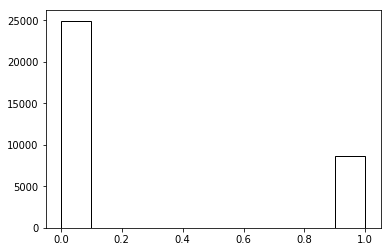

In [19]:
# First let's see what we're going to be fitting:
plt.hist(data_all["selection_tag"], color='k', histtype='step')
plt.show()

In [20]:
# The modules we're going to need
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [21]:
import statsmodels as sm

### Probit Regression on the whole dataset

In [22]:
# First take a look at regression on the whole dataset
from patsy import dmatrices  # neat helper module from patsy

Z, phi = dmatrices('selection_tag ~ S2mB + S2c + S2x1', data_all, return_type = 'dataframe')
probit_model = sm.discrete.discrete_model.Probit(Z, phi)

probit_results = probit_model.fit(method='lbfgs')

In [23]:
print(probit_results.summary())

                          Probit Regression Results                           
Dep. Variable:          selection_tag   No. Observations:                33596
Model:                         Probit   Df Residuals:                    33592
Method:                           MLE   Df Model:                            3
Date:                Mon, 07 Jan 2019   Pseudo R-squ.:                  0.2288
Time:                        15:16:23   Log-Likelihood:                -14769.
converged:                       True   LL-Null:                       -19151.
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.1667      0.177     74.439      0.000      12.820      13.513
S2mB          -0.5812      0.007    -78.405      0.000      -0.596      -0.567
S2c           -0.0846      0.115     -0.734      0.4

In [23]:
probit_results.params

Intercept    20.733890
S2mB         -0.922779
S2c          -2.696767
S2x1          0.093179
dtype: float64

In [24]:
# take a look at the coefficients--use zip and then convert to a list
pd.DataFrame(list(zip(phi.columns, np.transpose(log_model.coef_))))

NameError: name 'log_model' is not defined

From here we can already see that the mB parameter has the largest (negative) slope. This makes sense from a physical standpoint since the larger the magnitude of a SN, the dimmer it will appear, making it less likely to be observed.

## Supervised Learning Probit Regression

Next we're going to split our data into train and test groups to do a supervised learning fit. We're going to split the observed data into two groups: 
- 25% into a "train" group to find our logistic regression coefficients
- 75% into a "test" group to test the accuracy of our selection function classifier

In [46]:
# Next, split the observed SNe into two groups:
# 25% data_train, 75% data_test
Z = np.ravel(Z) # flatten Z to 1D
phi_train, phi_test, Z_train, Z_test = train_test_split(phi, Z, train_size=0.25, test_size=0.75, random_state = 0)

# use limited-memory Broyden-Fletcher-Goldfarb-Shanno algorithm with no parameter regularization
probit_learn_model = sm.discrete.discrete_model.Probit(Z_train, phi_train) 
probit_results = probit_model.fit_regularized()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.43960562111612705
            Iterations: 29
            Function evaluations: 33
            Gradient evaluations: 29


In [47]:
print(probit_results.summary())

                          Probit Regression Results                           
Dep. Variable:          selection_tag   No. Observations:                33596
Model:                         Probit   Df Residuals:                    33592
Method:                           MLE   Df Model:                            3
Date:                Mon, 07 Jan 2019   Pseudo R-squ.:                  0.2288
Time:                        15:33:51   Log-Likelihood:                -14769.
converged:                       True   LL-Null:                       -19151.
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.1672      0.177     74.441      0.000      12.821      13.514
S2mB          -0.5812      0.007    -78.407      0.000      -0.596      -0.567
S2c           -0.0849      0.115     -0.736      0.4

In [48]:
# learning model coefficients--use zip and then convert to a list
print('Probit Regression Coefficients from Supervised Learning')
pd.DataFrame(list(zip(phi.columns, np.transpose(probit_results.params))))

Probit Regression Coefficients from Supervised Learning


,0,1
0,Intercept,13.167183
1,S2mB,-0.581248
2,S2c,-0.084884
3,S2x1,0.038799


We're now going to test our model on the test data. Using the above coefficients, we're going to try to predict whether a SN$_{test}$ was selected or not. Then, we'll compare the prediction to the actual distribution of selected vs unselected SN in the test sample

In [49]:
# unpack the parameters
pars = probit_results.params
eps,gm,gc,gx = pars

In [50]:
# From "selection_effects.py" This is the selection function for each latent variable
# The selection parameters are the coefficients we fitted above
# EXPONENTIATE to get the desired sigmoid curves
def log_indiv_selection_fn(phi_i, selection_param=(gm, gc, gx, eps)):
    coefs = np.array(selection_param)
    position = np.array([*phi_i, 1])
    argument = np.dot(coefs, position)
    return scipy.stats.norm.logcdf(np.sqrt(np.pi/8)*argument)# must be a logcdf so it dies/grows to 0/1 at the right speed

In [51]:
# unpack parameters to predict selection probability with the selection function
phi_test_list = []
for par in ['S2mB', 'S2c', 'S2x1']:
    phi_test_list.append(np.asarray(phi_test[par]))

In [61]:
# make predictions using the model and add results to "test" dataframe
phi_test.loc[:,"selection_prediction"] = pd.Series(np.exp((log_indiv_selection_fn(phi_test_list, 
                                                                                  selection_param=(gm,gc,gx,eps)))), 
                                                                                                   index=phi_test.index)  
phi_test["selection_prediction"] ;             

## Visualizing the Trained Selection Function Classifier
We're going to plot our trained classifier with respect to each latent variable to see how our fitted coefficients affect selectivity of SNIa$_{i_{test}}$ in the test dataset.

At the same time, we'll get a visual representation of the accuracy of our classifier by plotting the true selection $Z_i$ values for each SN$_i$. 
**RED = MISSED, BLUE = SELECTED**

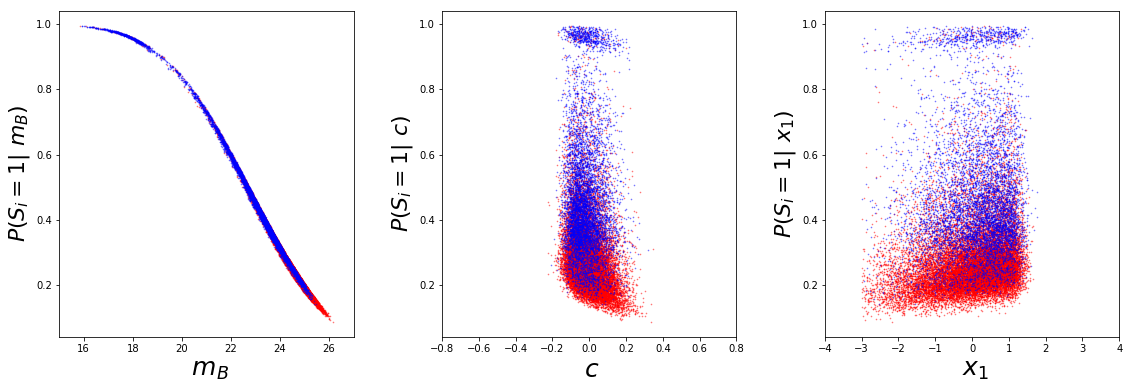

In [53]:
# Make a nifty plot to show the probability of selection in the test data as a function of one variable:
fig,axs = plt.subplots(1, 3, figsize = (19,6))
par_tags = ['S2mB', 'S2c', 'S2x1']
latent_names = [' $m_B$', ' $c$', ' $x_1$']
xlims = [(15, 27), (-0.8, 0.8), (-4, 4)]

# split the selected SNe from the missed SNe
select_mask_true = Z_test.astype(bool)             # masks of all selected (Z = 1) SNe
missed_mask_true = np.invert(select_mask_true)     # mask of all missed SNe

# unpack parameters to plot cross-sections with the selection function
phi_test_plot = []
for par in ['S2mB', 'S2c', 'S2x1']:
    phi_test_plot.append(np.asarray(phi_test[par]))

phi_missed = []
phi_select = []
for parameter in phi_test_plot:
    phi_missed.append(parameter[missed_mask_true])
    phi_select.append(parameter[select_mask_true])


for i in range(len(axs)):
    # plot missed SNe
    axs[i].scatter(phi_test[par_tags[i]].iloc[missed_mask_true][::1], 
                    phi_test['selection_prediction'].iloc[missed_mask_true][::1], 
                            color='r', marker = '.', alpha=0.5, s=1.5, label='Missed')
    
    # plot selected SNe
    axs[i].scatter(phi_test[par_tags[i]].iloc[select_mask_true][::1], 
                   phi_test['selection_prediction'].iloc[select_mask_true][::1], 
                         color='b', marker = '.', alpha=0.5, s=1.5, label='Selected')
    
    # restrict xlims to observed SNe    
    axs[i].set_xlim(xlims[i])    
    # add labels
    axs[i].set_xlabel(latent_names[i], fontsize=25)
    axs[i].set_ylabel('$P(S_i=1|$' + latent_names[i] + '$)$', fontsize=22)

#fig.suptitle('Selection Function Classifier on Test SNIa set', fontsize=17)
#plt.legend(loc='best')
plt.subplots_adjust(wspace=0.3, left=0.125)
plt.savefig(fname='/mnt/c/Users/lucas/Documents/Fall2018/Imperial_2018/JP2/plots/paper_figs/selection_probit_fn.png', dpi='figure')
plt.show()

**BLUE = SELECTED**, **RED = MISSED** The colors represent whether or not each SNANA simulated SNIa$_{i_{test}}$ in the test dataset was truely selected

From these cutaways, we see that $m_B$ has the greatest effect on whether or not a SN will be selected. "Stretch" x1 has almost no effect on the selectivity (very small coefficient).

In [54]:
# Using sk-learn, 
false_pos_rate,true_pos_rate,thresholds = metrics.roc_curve(y_true=Z_test, y_score=phi_test['selection_prediction'])

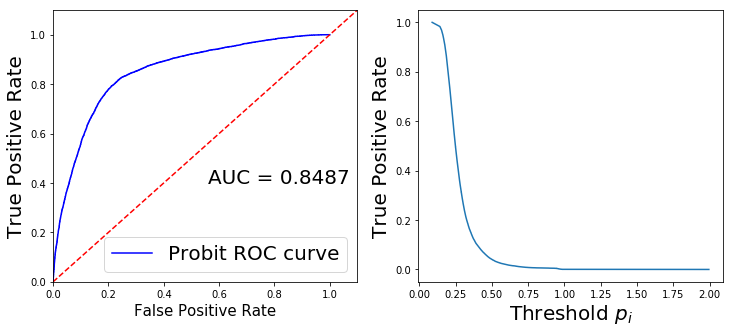

In [83]:
fig,axs = plt.subplots(1,2, figsize = (12, 5))
axs[0].plot(false_pos_rate, true_pos_rate, color='b', label='Probit ROC curve')
axs[0].plot(np.linspace(0, 1.1, num=50), np.linspace(0, 1.1, num=50), linestyle='--', color='r')
axs[0].set_xlabel('False Positive Rate', fontsize=15)
axs[0].set_xlim(0,1.1)
axs[0].set_ylim(0,1.1)
axs[0].set_ylabel('True Positive Rate', fontsize=20)
axs[0].legend(loc='best', fontsize=20)

axs[1].plot(thresholds, false_pos_rate)
axs[1].set_xlabel('Threshold $p_i$', fontsize=20)
axs[1].set_ylabel('True Positive Rate', fontsize=20)
score = metrics.roc_auc_score(Z_test, phi_test['selection_prediction'])
axs[0].text(x=0.56, y=0.4, s='AUC = %.4f' %score , fontsize=20)

plt.savefig('/c/Users/lucas/Documents/Fall2018/Imperial_2018/JP2/plots/paper_figs/probit_roc.png', dpi='figure')

plt.show()


So, taking a look at the first curve, we see that as we increase the chance of falsely selecting a SNIa, the true positive rate (TPR) shoots up. This is great news for our classifier, since we want our TPR *as close to 1 as possible* (upper left corner)--this would make our classifier 100% sensitive. A bad classifier would show our ROC curve below the red line, which represents a random guess (TPR = FPR). The space to the lower right represents a classifier that identifies more false positives than true positives (meaning you'd need to re-evaluate your selection criteria!)

We can take a look at the ROC accuracy metric, which is the area under the ROC curve. If we had perfect sensitivity, our ROC curve would shoot right up to 1.0 as a step function, making the area under the curve = 1. Let's use Scikit-Learn to compute the area under the curve. This is the probability that our selection function will rank true positive selectino higher than false positive selection:

In [37]:
print("Area under ROC curve = Probability of correct selection = ", metrics.roc_auc_score(Z_test, probs[:, 1]))

Area under ROC curve = Probability of correct selection =  0.8488523734767518


In [38]:
# make Z predicted
Z_predict = (np.asarray(phi_test['selection_prediction']) > .1)
Z_predict = Z_predict.astype(int)

sum(Z_predict)

16848

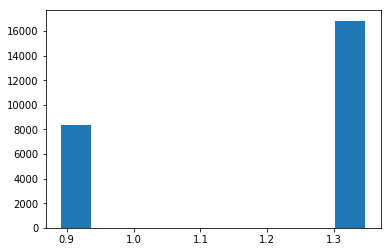

In [39]:
plt.hist(phi_test['S2x1'].values[Z_predict])
plt.show()

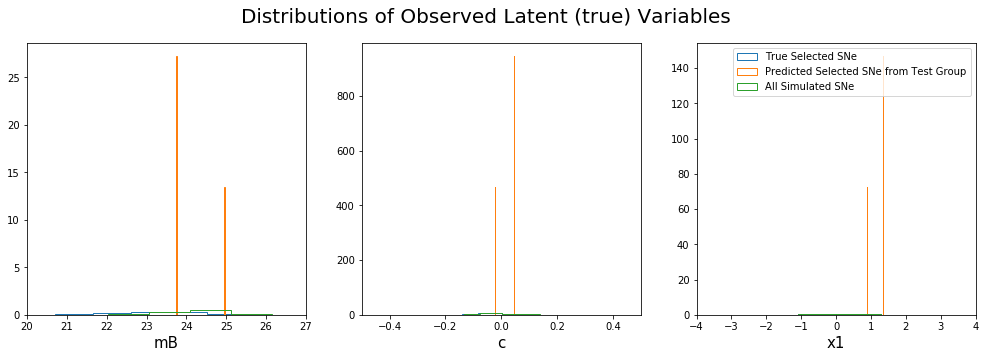

In [40]:

# define lists of plotting features for latent mB, c, & x1
sel_names = ["SIM_mB", 'SIM_c', 'SIM_x1']
obs_names = ['S2mB', 'S2c', 'S2x1']
xlims = [(20, 27), (-0.5, 0.5), (-4, 4)]
binz = [10, 50, 20]
predbins = [50, 100, 100]
fig,axs = plt.subplots(1, 3, figsize = (17,5))

for i in range(len(axs)):
    axs[i].hist(data_sel[sel_names[i]], histtype='step', bins=binz[i], label='True Selected SNe', stacked=True, density=True)
    axs[i].hist(phi_test[obs_names[i]].iloc[Z_predict], histtype='step', bins=predbins[i], stacked=True, label='Predicted Selected SNe from Test Group', density=True)
    axs[i].hist(phi_test[obs_names[i]], histtype='step', bins=binz[i], label='All Simulated SNe', stacked=True, density=True)
    axs[i].set_xlabel(obs_names[i][2:], fontsize=15)
    
    axs[i].set_xlim(xlims[i])

fig.suptitle("Distributions of Observed Latent (true) Variables", fontsize=20)
plt.legend(loc='best')
plt.show()

In [41]:
len(data_all)
len(Z_predict)

25197

## Powerlaw Fitting for redshift distribution of bulk SNIa

We're interested in fitting the probability distribution $p(z)$ to create a predictive model for how many SNIa we can expect to find at a given redshift. Looking at the distribution of $z$, we'll try fitting a powerlaw model to begin with:

# $$p(z) = Bz^{-\alpha}$$

In [42]:
# define our powerlaw function we want to fit
def powerlaw_z(z, a, b):
    return b * z**(a)

In [67]:
# next, bin the data. Let's choose nbins = 20 to start.
nbins = 10
zdata = data_all['GENZ'].values

bins = np.linspace(0, max(zdata), nbins)

bin_zdata = np.histogram(zdata, bins)

In [68]:
z_values = bin_zdata[1][1:]    # get z values to fit to
y_values = bin_zdata[0]        # the "y" values we're fitting to

y_norm = y_values / np.sum(y_values)   # this is a probability distribution,
                                       # so the area under the curve sums to 1.

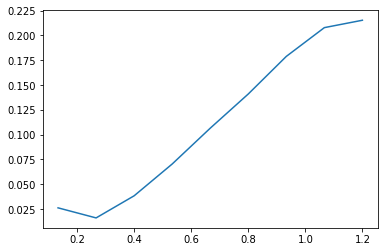

In [69]:
plt.plot(z_values,y_values / np.sum(y_values))
plt.show()

In [70]:
# now fit the powerlaw model using scipy.optimize.curvefit 
#(nonlinear least squares fiting)
from scipy.optimize import curve_fit

In [71]:
powerlaw_fit = curve_fit(powerlaw_z, z_values, y_values/np.sum(y_values))

In [72]:
a_fit = powerlaw_fit[0][0]
B_fit = powerlaw_fit[0][1]

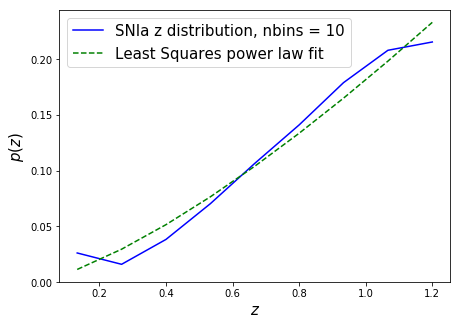

Parameters 
 a = 1.372629338228674 
 B = 0.1812769830095274


In [74]:
fig,ax = fig,axs = plt.subplots(1, 1, figsize = (7,5))
ax.plot(z_values,y_values/(np.sum(y_values)), color = 'b', 
        label='SNIa z distribution, nbins = {}'.format(nbins))        # data
ax.plot(z_values, powerlaw_z(z_values, a_fit, B_fit), 
        color = 'g', linestyle = '--', label = r'Least Squares power law fit')


ax.set_xlabel('$z$', fontsize=15)
ax.set_ylabel('$p(z)$', fontsize=15)
plt.legend(loc = 'best', fontsize=15)
plt.savefig(fname='/mnt/c/Users/lucas/Documents/Fall2018/Imperial_2018/JP2/plots/paper_figs/powerlaw.png', dpi='figure')
plt.show()


print("Parameters \n a = {} \n B = {}".format(a_fit, B_fit))